# How to customize a synapse

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_building/how_to_customze_a_synapse.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_building/how_to_customze_a_synapse.ipynb)

In [1]:
import numpy as np
import brainpy.version2 as bp
import brainpy.version2.math as bm

import matplotlib.pyplot as plt

## Preparations

### ``brainpy.dyn.ProjAlignPostMg2``

![](../_static/align_post.png)

Synaptic projection which defines the synaptic computation with the dimension of postsynaptic neuron group.

```
brainpy.dyn.ProjAlignPostMg2(
   pre, 
   delay, 
   comm, 
   syn, 
   out, 
   post
)
```

- ``pre (JointType[DynamicalSystem, AutoDelaySupp])``: The pre-synaptic neuron group.
- ``delay (Union[None, int, float])``: The synaptic delay.
- ``comm (DynamicalSystem)``: The synaptic communication.
- ``syn (ParamDescInit)``: The synaptic dynamics.
- ``out (ParamDescInit)``: The synaptic output.
- ``post (DynamicalSystem)`` The post-synaptic neuron group.

### ``brainpy.dyn.ProjAlignPreMg2``

Synaptic projection which defines the synaptic computation with the dimension of presynaptic neuron group.

```
brainpy.dyn.ProjAlignPreMg2(
   pre, 
   delay,
   syn,  
   comm, 
   out, 
   post
)
```

- ``pre (JointType[DynamicalSystem, AutoDelaySupp])``: The pre-synaptic neuron group.
- ``delay (Union[None, int, float])``: The synaptic delay.
- ``syn (ParamDescInit)``: The synaptic dynamics.
- ``comm (DynamicalSystem)``: The synaptic communication.
- ``out (ParamDescInit)``: The synaptic output.
- ``post (DynamicalSystem)`` The post-synaptic neuron group.


![](../_static/align_pre.png)


## Synapse dynamics

### Exponential Model

The single exponential decay synapse model assumes the release of neurotransmitter, its diffusion across the cleft, the receptor binding, and channel opening all happen very quickly, so that the channels instantaneously jump from the closed to the open state. Therefore, its expression is given by

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} e^{-\left(t-t_{0}\right) / \tau}
$$

where $\tau$ is the time constant, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\frac{d g}{d t} = -\frac{g}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}).
$$

Only Exponential synapse model can use the ``AlignPost``. 


In [2]:
class Exponen(bp.dyn.SynDyn, bp.mixin.AlignPost):
  def __init__(self, size, tau):
    super().__init__(size)
    
    # parameters
    self.tau = tau
    
    # variables
    self.g = bm.Variable(bm.zeros(self.num))
    
    # integral
    self.integral = bp.odeint(lambda g, t: -g/tau, method='exp_auto')  
  
  def update(self, pre_spike=None):
    self.g.value = self.integral(g=self.g.value, t=bp.share['t'], dt=bp.share['dt'])
    if pre_spike is not None:
      self.add_current(pre_spike)
    return self.g.value
      
  def add_current(self, x):  # specical for bp.mixin.AlignPost
    self.g += x
    
  def return_info(self):
    return self.g

### AMPA model

AMAP synapse is described by a differential equation.

$$
\frac {ds}{dt} = \alpha [T] (1-s) - \beta s
$$

Where $\alpha [T]$ denotes the transition probability from state $(1-s)$ to state $(s)$; and $\beta$ represents the transition probability of the other direction. $\alpha=0.98$ is the binding constant. $\beta=.18$ is the unbinding constant. $T=.5\, mM$ is the neurotransmitter concentration, and has the duration of 0.5 ms.

In [3]:
class AMPA(bp.dyn.SynDyn):
  def __init__(self, size, alpha= 0.98, beta=0.18, T=0.5, T_dur=0.5):
    super().__init__(size=size)

    # parameters
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.T_duration = T_dur

    # functions
    self.integral = bp.odeint(method='exp_auto', f=self.dg)
    
    # variables
    self.g = bm.Variable(bm.zeros(self.num))
    self.spike_arrival_time = bm.Variable(bm.ones(self.num) * -1e7)

  def dg(self, g, t, TT):
    return self.alpha * TT * (1 - g) - self.beta * g
  
  def update(self, pre_spike):
    self.spike_arrival_time.value = bm.where(pre_spike, bp.share['t'], self.spike_arrival_time)
    TT = ((bp.share['t'] - self.spike_arrival_time) < self.T_duration) * self.T
    self.g.value = self.integral(self.g, bp.share['t'], TT, bp.share['dt'])
    return self.g.value

  def return_info(self):
    return self.g

## Synapse outputs

### COBA

Given the synaptic conductance, the COBA model outputs the post-synaptic current with

$$
I_{syn}(t) = g_{\mathrm{syn}}(t) (E - V(t))
$$


In [4]:
class COBA(bp.dyn.SynOut):
  def __init__(self, E):
    super().__init__()
    self.E = E

  def update(self, conductance, potential):
    return conductance * (self.E - potential)

### CUBA

Given the conductance, this model outputs the post-synaptic current with a identity function:

$$
I_{\mathrm{syn}}(t) = g_{\mathrm{syn}}(t)
$$

In [5]:
class CUBA(bp.dyn.SynOut):
  def __init__(self, E):
    super().__init__()
    self.E = E

  def update(self, conductance, potential):
    return conductance

### Mg Blocking

The voltage dependence is due to the blocking of the pore of the NMDA receptor from the outside by a positively charged magnesium ion. The channel is nearly completely blocked at resting potential, but the magnesium block is relieved if the cell is depolarized. The fraction of channels $B(V)$ that are not blocked by magnesium can be fitted to

$$
B(V) = {1 \over 1 + \exp(-0.062V) [Mg^{2+}]_o/3.57}
$$

Here, $[{Mg}^{2+}]_{o}$ is the extracellular magnesium concentration, usually 1 mM. 

If we make the approximation that the magnesium block changes instantaneously with voltage and is independent of the gating of the channel, the net NMDA receptor-mediated synaptic current is given by

$$
I=\bar{g}sB(V)(V-E)
$$

where $V(t)$ is the post-synaptic neuron potential, $E$ is the reversal potential.

In [6]:
class MgBlock(bp.dyn.SynOut):
  def __init__(self, E= 0., cc_Mg= 1.2, alpha= 0.062, beta= 3.57):
    super().__init__()
    self.E = E
    self.cc_Mg = cc_Mg
    self.alpha = alpha
    self.beta = beta

  def update(self, conductance, potential):
    return conductance * (self.E - potential) / (1 + self.cc_Mg / self.beta * bm.exp(-self.alpha * potential))

## Synaptic communications

### Masked matrix

![](../_static/masked_matrix.png)

In [7]:
class MaskedLinear(bp.dnn.Layer):
  def __init__(self, conn, weight):
    super().__init__()
    
    # connection and weight
    weight = bp.init.parameter(weight, (conn.pre_num, conn.post_num))
    if isinstance(self.mode, bm.TrainingMode):
      weight = bm.TrainVar(weight)
    self.weight = weight

    # connection
    self.conn = conn
    self.mask = bm.sharding.partition(self.conn.require('conn_mat'))

  def update(self, x):
    return x @ (self.weight * self.mask)

## Examples

In [8]:
class SimpleNet(bp.DynSysGroup):
  def __init__(self, proj, g_max=1.):
    super().__init__()
    
    self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = proj(self.pre, self.post, delay=None, prob=1., g_max=g_max)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

In [9]:
def run_a_net(net):
  indices = np.arange(1000)  # 100 ms
  conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
  
  # --- similar to: 
  # runner = bp.DSRunner(net)
  # conductances, currents, potentials = runner.run(100.)
  
  ts = indices * bm.get_dt()
  fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
  fig.add_subplot(gs[0, 0])
  plt.plot(ts, conductances)
  plt.title('Syn conductance')
  fig.add_subplot(gs[0, 1])
  plt.plot(ts, currents)
  plt.title('Syn current')
  fig.add_subplot(gs[0, 2])
  plt.plot(ts, potentials, label='Post V')
  plt.legend()
  plt.show()

### Exponential COBA

In [10]:
class ExponCOBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau=5., E=0.):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, 
      delay=delay, 
      comm=MaskedLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      syn=Exponen.desc(post.num, tau=tau),
      out=COBA.desc(E=E),
      post=post, 
    )

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

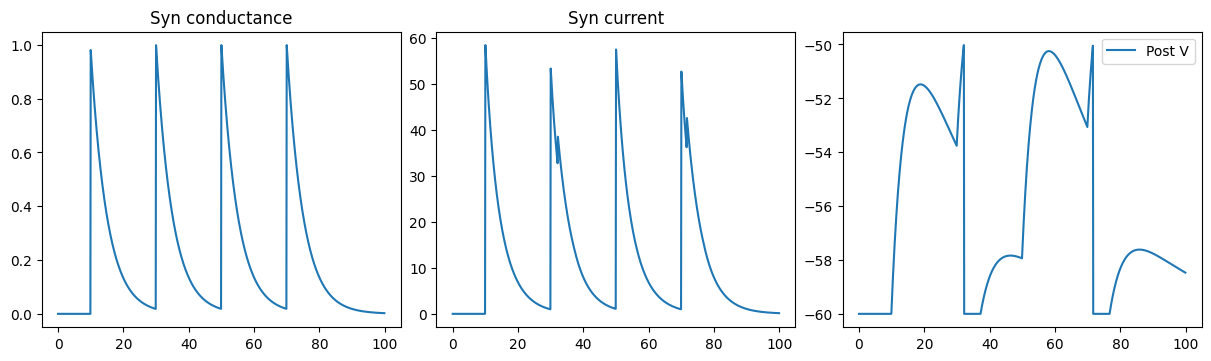

In [11]:
run_a_net(SimpleNet(ExponCOBA))

### AMPA NMDA

In [12]:
class AMPA_NMDA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, E=0.):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, 
      delay=delay, 
      syn=AMPA.desc(post.num),
      comm=MaskedLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      out=MgBlock(E=E),
      post=post, 
    )

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

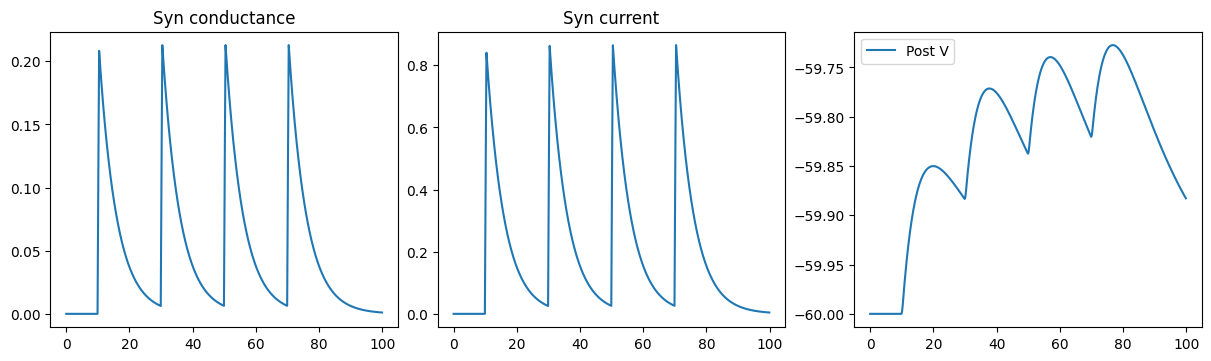

In [13]:
run_a_net(SimpleNet(AMPA_NMDA))